In [ ]:
%load_ext autoreload
%autoreload 2

import os
from os.path import realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

In [ ]:
%pip install mercantile

In [4]:
# Preamble

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

from dataclasses import astuple

import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve

#external
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T

#own
import mbt_util as M
import bbox
from src import img_util as G, mbt_download as MD, mbt_partial as MP, swisstopo as SS
from src.swisstopo import bbchsw, bbchsc, bbchse, bbchc, bbchn

In [5]:
def tree():
    """Return a tree of tuples representing the logger layout.
    Each tuple looks like ``('logger-name', <Logger>, [...])`` where the
    third element is a list of zero or more child tuples that share the
    same layout.
    """
    root = ('', logging.root, [])
    nodes = {}
    items = list(logging.root.manager.loggerDict.items())  # for Python 2 and 3
    items.sort()
    for name, logger in items:
        nodes[name] = node = (name, logger, [])
        i = name.rfind('.', 0, len(name) - 1)  # same formula used in `logging`
        if i == -1:
            parent = root
        else:
            parent = nodes[name[:i]]
        parent[2].append(node)
    return root

tree()

('',
 <RootLogger root (DEBUG)>,
 [('IPKernelApp', <Logger IPKernelApp (WARNING)>, []),
  ('PIL', <Logger PIL (INFO)>, [('PIL.Image', <Logger PIL.Image (INFO)>, [])]),
  ('asyncio', <Logger asyncio (DEBUG)>, []),
  ('concurrent',
   [('concurrent.futures', <Logger concurrent.futures (DEBUG)>, [])]),
  ('parso',
   [('parso.cache', <Logger parso.cache (DEBUG)>, []),
    ('parso.python',
     [('parso.python.diff', <Logger parso.python.diff (DEBUG)>, [])])]),
  ('pkg_resources',
   [('pkg_resources.extern',
     [('pkg_resources.extern.packaging',
       [('pkg_resources.extern.packaging.tags',
         <Logger pkg_resources.extern.packaging.tags (DEBUG)>,
         [])])])]),
  ('prompt_toolkit',
   [('prompt_toolkit.buffer', <Logger prompt_toolkit.buffer (DEBUG)>, [])]),
  ('tornado',
   <Logger tornado (DEBUG)>,
   [('tornado.access', <Logger tornado.access (DEBUG)>, []),
    ('tornado.application', <Logger tornado.application (DEBUG)>, []),
    ('tornado.general', <Logger tornado.gene

In [6]:
cdir = pjoin(NBROOT, '../data/sample_ch')
os.makedirs(cdir, exist_ok=True)
%cd $cdir

/home/eoubrayrie/code/eddy-geek/etopo/data/sample_ch



---

## WMTS download

I have cut this in 5 parts to keep size manageable

| id     | bounds |
| --     | --     |
| chsw   | AixB-Thun          |
| chsc   | Challand-Vuorz    |
| chse   | Morbegno-Resia    |
| chc    | Pontarlier-Pfunds |
| chn    | Morteau-Opfenbach |


In [10]:
T.bounds(T.tile(*bbox.llzmutt, zoom=17))

LngLatBbox(west=7.71514892578125, south=46.00459325574481, east=7.7178955078125, north=46.006501000652584)

In [ ]:
# Explore mercantile lib
bb = astuple(SS.bbchsw.enlarge(-0.000005))
# bb = astuple(bbchsw)

for z in 9, 10, 11, 12, 16:
    print(f'z{z} :', len(list(T.tiles(*bb, [z]))))
# 9 25 90 360

t = list(T.tiles(*bb, [10]))
assert len(t) == 25
t

# we expect: x=529->533  y=361->365

z9 : 9
z10 : 25
z11 : 90
z12 : 360
z16 : 92160


[Tile(x=529, y=361, z=10),
 Tile(x=529, y=362, z=10),
 Tile(x=529, y=363, z=10),
 Tile(x=529, y=364, z=10),
 Tile(x=529, y=365, z=10),
 Tile(x=530, y=361, z=10),
 Tile(x=530, y=362, z=10),
 Tile(x=530, y=363, z=10),
 Tile(x=530, y=364, z=10),
 Tile(x=530, y=365, z=10),
 Tile(x=531, y=361, z=10),
 Tile(x=531, y=362, z=10),
 Tile(x=531, y=363, z=10),
 Tile(x=531, y=364, z=10),
 Tile(x=531, y=365, z=10),
 Tile(x=532, y=361, z=10),
 Tile(x=532, y=362, z=10),
 Tile(x=532, y=363, z=10),
 Tile(x=532, y=364, z=10),
 Tile(x=532, y=365, z=10),
 Tile(x=533, y=361, z=10),
 Tile(x=533, y=362, z=10),
 Tile(x=533, y=363, z=10),
 Tile(x=533, y=364, z=10),
 Tile(x=533, y=365, z=10)]

In [125]:
# check relative sizes of the bounds. with download times of 1 hour for 10 z11 tiles (for up to zoom<=16),
# better avoid too big areas.

for var in('bbchsw', 'bbchsc', 'bbchse', 'bbchc', 'bbchn'):
    b = locals()[var]
    bb = astuple(b.enlarge(-0.000005))
    print(f'z{var} :', len(list(T.tiles(*bb, [11]))))

zbbchsw : 90
zbbchsc : 90
zbbchse : 36
zbbchc : 48
zbbchn : 90


0.008889436721801758 seconds


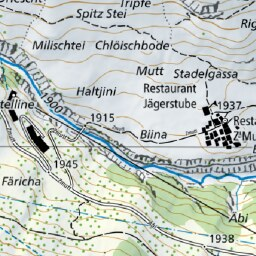

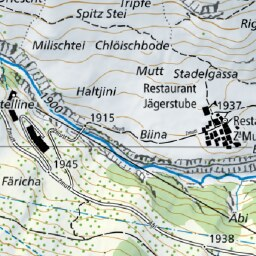

In [ ]:
# Check conversion of PNG to jpeg, as landeskarte-farbe-10 is png only and mbtiles should better be same format
from time import time

start = time()
path = 'tiles/wmts100.geo.admin.ch^1.0.0^ch.swisstopo.landeskarte-farbe-10^default^current^3857^16^34172^23313.jpeg'
im = open(path, 'rb').read()
imj = G.to_jpeg(im)
with open('foo.jpeg', 'wb') as f:
    f.write(imj)
print(time() - start, 'seconds')

display(Image(path))
Image('foo.jpeg')

In [29]:
# Based on `explore-SwissTopo-2-api.ipynb` I wrote `bbox_to_mbt`
#bbchsw = bbox.BBox(5.976563, 45.706182,  7.734378, 46.800062)
MD.bbox_to_mbt('test.mbtiles', bbchsw, [9], 'jpeg', SS.geturl_ch_downsampled)

Inserted 0. 9 reused. Status: 9 / 9


In [177]:
MD.bbox_to_mbt('ch.mbtiles', bbchse, [9,10,11,12,13,14,15,16], 'jpeg', SS.geturl_ch_downsampled)

# 50K tiles at 4.5 tiles/second or 16K/hour, 3 hours

Inserting 0 ...Status... 0 / 49153
Inserting 100 ...Status... 100 / 49153
Inserting 100 ...Status... 200 / 49153
Inserting 100 ...Status... 300 / 49153
Inserting 100 ...Status... 400 / 49153
Inserting 100 ...Status... 500 / 49153
Inserting 100 ...Status... 600 / 49153
Inserting 100 ...Status... 700 / 49153
Inserting 100 ...Status... 800 / 49153
Inserting 100 ...Status... 900 / 49153
Inserting 100 ...Status... 1000 / 49153
Inserting 100 ...Status... 1100 / 49153
Inserting 100 ...Status... 1200 / 49153
Inserting 100 ...Status... 1300 / 49153
Inserting 100 ...Status... 1400 / 49153
Inserting 100 ...Status... 1500 / 49153
Inserting 100 ...Status... 1600 / 49153
Inserting 100 ...Status... 1700 / 49153
Inserting 100 ...Status... 1800 / 49153
Inserting 100 ...Status... 1900 / 49153
Inserting 100 ...Status... 2000 / 49153
Inserting 100 ...Status... 2100 / 49153
Inserting 100 ...Status... 2200 / 49153
Inserting 100 ...Status... 2300 / 49153
Inserting 100 ...Status... 2400 / 49153
Inserting 100 

In [178]:
MD.bbox_to_mbt('ch.mbtiles', bbchsw, [9,10,11,12,13,14,15,16], 'jpeg', SS.geturl_ch_downsampled)

# 123K tiles, >7 hours

Inserting 0 ...Status... 0 / 122884
Inserting 100 ...Status... 100 / 122884
Inserting 100 ...Status... 200 / 122884
Inserting 100 ...Status... 300 / 122884
Inserting 100 ...Status... 400 / 122884
Inserting 100 ...Status... 500 / 122884
Inserting 100 ...Status... 600 / 122884
Inserting 100 ...Status... 700 / 122884
Inserting 100 ...Status... 800 / 122884
Inserting 100 ...Status... 900 / 122884
Inserting 100 ...Status... 1000 / 122884
Inserting 100 ...Status... 1100 / 122884
Inserting 100 ...Status... 1200 / 122884
Inserting 100 ...Status... 1300 / 122884
Inserting 100 ...Status... 1400 / 122884
Inserting 100 ...Status... 1500 / 122884
Inserting 100 ...Status... 1600 / 122884
Inserting 100 ...Status... 1700 / 122884
Inserting 100 ...Status... 1800 / 122884
Inserting 100 ...Status... 1900 / 122884
Inserting 100 ...Status... 2000 / 122884
Inserting 100 ...Status... 2100 / 122884
Inserting 100 ...Status... 2200 / 122884
Inserting 100 ...Status... 2300 / 122884
Inserting 100 ...Status... 240

In [35]:
MD.bbox_to_mbt('ch.mbtiles', bbchsc, [9,10,11,12,13,14,15,16], 'jpeg', SS.geturl_ch_downsampled)

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 100 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 200 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 300 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 400 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 500 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 600 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 700 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 800 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 900 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1000 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1100 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1200 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1300 / 122884
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1400 /

In [61]:
MD.bbox_to_mbt('chc.mbtiles', bbchc, [9,10,11,12,13,14,15,16], 'jpeg', SS.geturl_ch_downsampled)
# > 30h

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 100 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 200 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 300 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 400 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 500 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 600 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 700 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 800 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 900 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1000 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1100 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1200 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1300 / 65538
Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 1400 / 65538
Added 0

In [ ]:
MD.bbox_to_mbt('ch.mbtiles', bbchn, [9,10,11,12,13,14,15,16], 'jpeg', SS.geturl_ch_downsampled)

In [ ]:
!ls -l *.mbtiles

In [63]:
M.update_mbt_meta('ch.mbtiles', desc=
'''Switzerland SwissTopo National Map. https://map.geo.admin.ch
Unlike the website, this is a downscaled version (1 zoom level up for each layer).''')

cp chsw.mbtiles ch.mbtiles
<<>> chsw : zoom = 9 16 ; n = 122884 ; bounds = 5.976563,45.706182,7.734378,46.800062 ; format = jpeg
<< chsc : zoom = 9 16 ; n = 122884 ; bounds = 7.734378,45.706182,9.492183,46.800062 ; format = jpeg
>> ch : zoom = 9 16 ; n = 245768 ; bounds = 5.976563,45.706182,9.492183,46.800062 ; format = jpeg
<< chse : zoom = 9 16 ; n = 49153 ; bounds = 9.492183,46.073229,10.546877,46.800062 ; format = jpeg
>> ch : zoom = 9 16 ; n = 294919 ; bounds = 5.976563,45.706182,10.546877,46.800062 ; format = jpeg
<< chc : zoom = 9 16 ; n = 65538 ; bounds = 6.328128,46.800062,10.546877,47.04018 ; format = jpeg
>> ch : zoom = 9 16 ; n = 360451 ; bounds = 5.976563,45.706182,10.546877,47.04018 ; format = jpeg
ch Merge of the following files:
* chsw : 
* chsc : 
* chse : 
* chc : 



## Do cleanup

In [ ]:
MP.clean_missing_data('ch.mbtiles')

# 1 hour

Deleted 0. Status: 0 / 49153
Deleted 0. Status: 200 / 49153
Deleted 16. Status: 400 / 49153
Deleted 16. Status: 600 / 49153
Deleted 59. Status: 800 / 49153
Deleted 15. Status: 1000 / 49153
Deleted 15. Status: 1200 / 49153
Deleted 13. Status: 1400 / 49153
Deleted 12. Status: 1600 / 49153
Deleted 12. Status: 1800 / 49153
Deleted 12. Status: 2000 / 49153
Deleted 12. Status: 2200 / 49153
Deleted 14. Status: 2400 / 49153
Deleted 11. Status: 2600 / 49153
Deleted 8. Status: 2800 / 49153
Deleted 124. Status: 3000 / 49153
Deleted 91. Status: 3200 / 49153
Deleted 61. Status: 3400 / 49153
Deleted 42. Status: 3600 / 49153
Deleted 43. Status: 3800 / 49153
Deleted 42. Status: 4000 / 49153
Deleted 42. Status: 4200 / 49153
Deleted 46. Status: 4400 / 49153
Deleted 50. Status: 4600 / 49153
Deleted 50. Status: 4800 / 49153
Deleted 43. Status: 5000 / 49153
Deleted 42. Status: 5200 / 49153
Deleted 68. Status: 5400 / 49153
Deleted 70. Status: 5600 / 49153
Deleted 70. Status: 5800 / 49153
Deleted 70. Status:

(defaultdict(int,
             {'': 25739,
              'partial': 726,
              'small': 22546,
              'tooblackorwhite': 129,
              'fewcolors': 13}),
 defaultdict(int,
             {'': 69838,
              'small': 51530,
              'partial': 1374,
              'tooblackorwhite': 132,
              'fewcolors': 10}),
 defaultdict(int,
             {'': 76004,
              'partial': 1486,
              'small': 45198,
              'tooblackorwhite': 185,
              'fewcolors': 11}))

# Fill with zoomed in data

Now we got "compressed" data, but some of it is missing especially at z16. Let's try to fill the blank with the original z16 data (instead of the 50% z17 data)

In [34]:
# `ch_fill` moved to swisstopo.py

# try to fill invalid/partial tiles 

SS.ch_fill('clean_ch.mbtiles', 'backup_ch.mbtiles')
# Image(urlopen('https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe/default/current/3857/17/68345/46627.jpeg').read(), height=256)
# ~50K tiles, ~5h

At: 1 for z10
At: 1 for z11
At: 1 for z12
At: 1 for z13
At: 1001 for z13
At: 1 for z14
At: 1001 for z14
At: 2001 for z14
At: 3001 for z14
At: 4001 for z14
At: 1 for z15
At: 1001 for z15
Added 122 tiles in 31.7 + 0.000 + 0.031 seconds. At: 1700 for z15. 122 downloaded so far.
Added 123 tiles in 47.4 + 0.000 + 0.021 seconds. At: 1800 for z15. 245 downloaded so far.
Added 62 tiles in 21.8 + 0.000 + 0.013 seconds. At: 1900 for z15. 307 downloaded so far.
Added 74 tiles in 19.2 + 0.000 + 0.016 seconds. At: 2000 for z15. 381 downloaded so far.
Added 58 tiles in 30.2 + 0.000 + 0.010 seconds. At: 2100 for z15. 439 downloaded so far.
Added 62 tiles in 20.8 + 0.000 + 0.012 seconds. At: 2200 for z15. 501 downloaded so far.
Added 70 tiles in 17.8 + 0.000 + 0.008 seconds. At: 2300 for z15. 571 downloaded so far.
Added 101 tiles in 30.8 + 0.001 + 0.019 seconds. At: 2400 for z15. 672 downloaded so far.
Added 59 tiles in 19.8 + 0.000 + 0.015 seconds. At: 2500 for z15. 731 downloaded so far.
Added 59 t

In [37]:
M.mbt_info('backup_ch.mbtiles')

'zoom = 10 16 ; n = 48967 ; bounds = 5.976563,45.706182,10.546877,47.04018 ; format = jpeg'

In [ ]:
# missing https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe/default/current/3857/16/34616/23175.jpeg

In [35]:
# Any transient network issue can be solved with:
# MD.tiles_to_mbt('zzcch.mbtiles', [T.Tile(34616,23175, 16)], bbox=None,
#                 format='jpeg', get_url=ch_url('pixelkarte-farbe', 'jpeg'))

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 1
Added 1 tiles in 0.3 + 0.0000 + 0.0017 seconds. Status: done!


## Merge partial

In [10]:
def ch_base_fallback(z, x, y):
    y = (1 << z) - y - 1
    get_url = SS.ch_url('pixelkarte-farbe', 'jpeg')
    rows = []
    try:
        _ = MD.download_tile_retry(format, get_url, rows, z, x, y)
        return rows[0][3]
    except:
        return None


In [11]:
%%prun -s cumulative -q -l 100 -T prun0
!cp -f test.mbtiles mtest.mbtiles
MP.fill_partial_data('mtest.mbtiles', 'zzcch.mbtiles', fallback_cbk=ch_base_fallback)

#1/34, z9: 
#1/34, z9: 

skip:34
 
*** Profile printout saved to text file 'prun0'. 


In [18]:
%%prun -s cumulative -q -l 100 -T prun0

!cp -f tocltest.mbtiles m4tocltest.mbtiles
MP.fill_partial_data('m4tocltest.mbtiles', 'zzcch.mbtiles', fallback_cbk=ch_base_fallback, debugmode=True)

#1/5000, z9: 
#1/5000, z9: 
#401/5000, z13: Inserted 7 in 0.0s and copied 7 and removed 0 in 0.0s
#601/5000, z13: Inserted 8 in 0.0s and copied 8 and removed 0 in 0.0s
#801/5000, z14: Inserted 33 in 0.0s and copied 33 and removed 0 in 2.0s
#2001/5000, z14: skip:1822, partial:merged:47, cross:overwrite:48, partial:help-partial:keep:2, partial:help-partial:remove:25, black&white:nohelp:remove:56
#2001/5000, z14: merge:0.84, db_copyrm:2.04, db_insert:0.02
#3201/5000, z15: Inserted 28 in 0.0s and copied 28 and removed 316 in 0.0s
#3401/5000, z15: Inserted 33 in 0.0s and copied 33 and removed 14 in 0.0s
#3601/5000, z15: Inserted 24 in 0.0s and copied 24 and removed 16 in 0.0s
#3801/5000, z15: Inserted 24 in 0.0s and copied 24 and removed 16 in 0.0s
#4001/5000, z15: skip:3363, partial:merged:72, cross:overwrite:181, partial:help-partial:keep:6, partial:help-partial:remove:72, black&white:nohelp:remove:119, cross:nohelp:remove:186, partial:downloaded:cross:help-cross:remove:1
#4001/5000, z15:

In [ ]:
# skip:4132, partial:merged:87, cross:overwrite:333, partial:help-partial:keep:2, partial:help-partial:remove:72, black&white:nohelp:remove:119, cross:nohelp:remove:254, partial:downloaded:cross:help-cross:remove:1
# skip:4132,
# partial:merged:160, 
# cross:overwrite:333, 
# black&white:nohelp:remove:119, 
# cross:nohelp:remove:254, 
# partial:downloaded-invalid:notfound:1, 
# partial:downloaded:merged:1

# {'skip': 3971,
#  'partial:merged': 76,
#  'cross:overwrite': 333,
#  'partial:notfound': 239,
#  'black&white:overwrite': 5,
#  'black&white:nohelp:remove': 122,
#  'cross:nohelp:remove': 254})


In [12]:
for line in open('prun0'):
    # if all(needle not in line for needle in ('request.py', 'client.py', 'ssl', 'spawn')):
    if any(needle in line for needle in ('mbt_', '_util.py', 'cbk', 'ch_base_fallback', 'ImageFile.py')):
        print(line, end='')

        1    0.002    0.002    0.169    0.169 mbt_download.py:213(fill_partial_data)
        1    0.021    0.021    0.077    0.077 mbt_util.py:251(from_db)
       34    0.003    0.000    0.064    0.002 img_util.py:134(to_numpy)
       34    0.003    0.000    0.054    0.002 ImageFile.py:154(load)
       34    0.000    0.000    0.015    0.000 img_util.py:225(bw_border_ratio)
       68    0.002    0.000    0.015    0.000 img_util.py:213(border_ratio)
    49260    0.010    0.000    0.010    0.000 mbt_util.py:277(zxy_to_i)
      272    0.004    0.000    0.010    0.000 img_util.py:200(np_equal)
       34    0.000    0.000    0.006    0.000 ImageFile.py:92(__init__)
       35    0.000    0.000    0.002    0.000 mbt_util.py:236(get_all_tiles)
       34    0.000    0.000    0.001    0.000 ImageFile.py:278(load_prepare)
      306    0.000    0.000    0.000    0.000 ImageFile.py:544(_safe_read)
       68    0.000    0.000    0.000    0.000 _util.py:5(isPath)
        1    0.000    0.000    0.000  

In [66]:
!grep download log_m4tocltest.mbtiles_1639578094.9823108.log

#2948/5000: z14 8669 10589 partial:downloaded-invalid:notfound0.8613281250.0
#3335/5000: z15 17250 21146 partial:downloaded:merged0.02343750.0


In [20]:
!cp -i ch.mbtiles mch.mbtiles
loglines = MP.fill_partial_data('mch.mbtiles', 'zzcch.mbtiles', fallback_cbk=ch_base_fallback)
# 13 minutes

#1/360451, z9: 
#1/360451, z9: 
#2001/360451, z14: skip:1940, partial:downloaded::merged:28, cross:overwrite:15, partial:merged:3, black&white:overwrite:14
#2001/360451, z14: download:4.68, insertdwn:0.01, merge:0.68
#2001/360451, z14: Inserted 29 in 0.0s and copied 29 and removed 0 in 0.0s
#2201/360451, z14: Inserted 71 in 0.0s and copied 71 and removed 0 in 0.0s
#2401/360451, z14: Inserted 69 in 0.0s and copied 69 and removed 0 in 0.0s
#2601/360451, z14: Inserted 85 in 0.0s and copied 85 and removed 1 in 0.0s
#2801/360451, z14: Inserted 87 in 0.0s and copied 87 and removed 0 in 0.0s
#3001/360451, z14: Inserted 82 in 0.0s and copied 82 and removed 0 in 0.1s
#3201/360451, z14: Inserted 68 in 0.0s and copied 68 and removed 0 in 0.0s
#3401/360451, z14: Inserted 76 in 0.0s and copied 76 and removed 0 in 0.0s
#3601/360451, z14: Inserted 84 in 0.0s and copied 84 and removed 0 in 0.1s
#3801/360451, z14: Inserted 84 in 0.0s and copied 84 and removed 0 in 0.0s
#4001/360451, z14: skip:3119, par

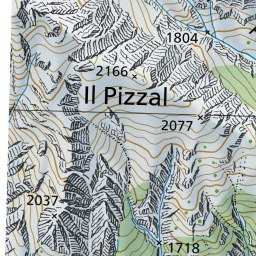

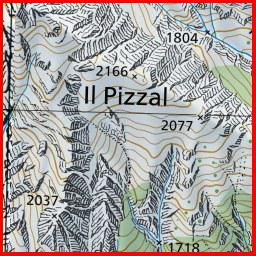

In [69]:
imd = M.num2tile('tocltest.mbtiles', 15, 17250, 21146, flip_y=False)
display(Image(imd))
imd = M.num2tile('m4tocltest.mbtiles', 15, 17250, 21146, flip_y=False)
display(Image(imd))

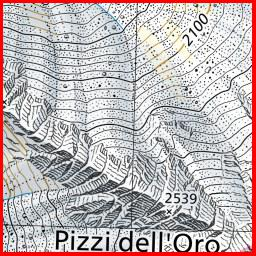

30841

In [60]:
imd = M.lnglat2tile('m2tocltest.mbtiles', 15, lng=9.55, lat=46.26)
assert(imd)
display(Image(imd))
len(imd)

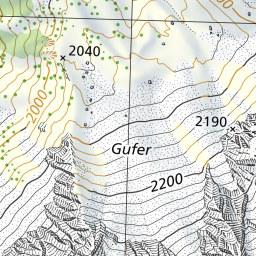

23137

In [ ]:
imd = M.num2tile('m2tocltest.mbtiles', 15, 17268, 21213)
assert(imd)
display(Image(imd))
len(imd)

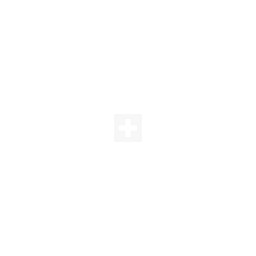

810

In [7]:
imd = M.num2tile('ch.mbtiles', 13, 4313, 5280)
assert(imd)
display(Image(imd))
len(imd)

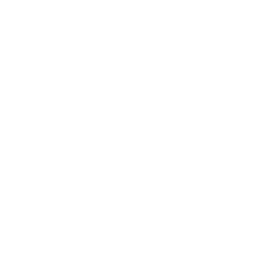

668

In [9]:
imd = M.num2tile('ch.mbtiles', 14, 8653, 10561)
assert(imd)
display(Image(imd))
len(imd)

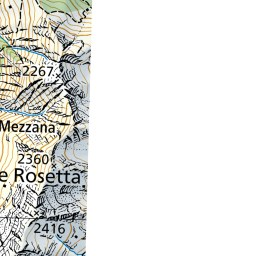

In [ ]:
imd = M.num2tile('ch.mbtiles', 13, 4312, 5280)
assert(imd)
display(Image(imd))

In [52]:
import io
import numpy as np
rgbmx = G.to_numpy(Img.open(io.BytesIO(imd)))
np.sum(G.np_equal(rgbmx, G.NP_WHITE)), np.sum(G.np_equal(rgbmx, G.NP_BLACK)), 0.95*256**2


(41417, 7, 62259.2)

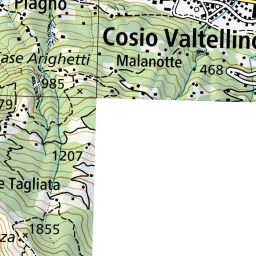

In [ ]:
imd = M.num2tile('ch.mbtiles', 13, 4312, 5281)
assert(imd)
display(Image(imd))

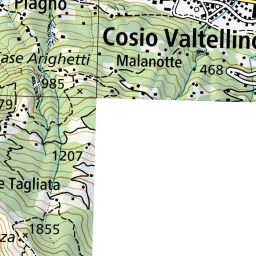

In [ ]:
imd = M.num2tile('mch.mbtiles', 13, 4312, 5281)
assert(imd)
display(Image(imd))

In [ ]:
# !aws s3 cp --acl public-read ./ch.mbtiles s3://topo/